In [1]:
from botorch.models.transforms import Normalize, Standardize
from torchvision import datasets, transforms
import torch
import numpy as np

from face_lib.models.losses import ArcFaceLoss
from face_lib.models.arcface import MetricLearningModel
from toy_scf.models import (
    Backbone,
    train_arcface,
    compute_cosine_sim,
    predict_accuracy,
    load_arcface_model,
    load_scf_model,
    train_scf,
    get_rejection_accuracy,
    compute_kappa,
)

## Experement setup

We construct OSCF protocol on mnist test set by marking of numbers as oog and spliting rest randomly between probe and gallery sets.  
Arcface and scf model are trained on mnist train part.  
Then we test our MC based OSFR method.

### 1. Train arcface model

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
mnist_ds_train = datasets.MNIST(
    root="/app/datasets/mnist", train=True, download=True, transform=transform
)
mnist_ds_test = datasets.MNIST(
    root="/app/datasets/mnist", train=False, download=True, transform=transform
)

In [3]:
# NUM_FEATURES = 2
# MAX_EPOCH = 30
# BATCH_SIZE = 400
# backbone_model = Backbone(num_features=NUM_FEATURES)
# arcface_loss = ArcFaceLoss()

# scheduler_params = {
#         "scheduler": "OneCycleLR",
#         "params": {
#             "max_lr": 3e-2,
#             "steps_per_epoch": len(mnist_ds_train) // BATCH_SIZE,
#             "epochs": MAX_EPOCH,
#             "div_factor": 1e2,
#             "final_div_factor": 1e2,
#         },
#         "interval": "step",
#         "frequency": 1,
#     }

# arcface_model = MetricLearningModel(
#     backbone_model,
#     arcface_loss,
#     num_labels=10,
#     train_set=mnist_ds_train,
#     val_set=mnist_ds_test,
#     batch_size=BATCH_SIZE,
#     num_workers=4,
#     scheduler_params=scheduler_params,
#     num_features=NUM_FEATURES,
# )
# run_name = "arcface_mnist"
# train_arcface(arcface_model, f"/app/outputs/mnist_train/{run_name}", project="ToyArcFaceMnist", run_name=run_name, max_epoch=MAX_EPOCH)

In [4]:
# arcface_model = load_arcface_model(
#     mnist_ds_train,
#     mnist_ds_test,
#     "/app/outputs/mnist_train/arcface_mnist/ckpt/epoch=29-val_loss=1.05.ckpt",
#     visualize=True,
# )

In [5]:
arcface_path = "/app/outputs/mnist_train/arcface_mnist/ckpt/epoch=29-val_loss=1.05.ckpt"
arcface_model = load_arcface_model(
    mnist_ds_train,
    mnist_ds_test,
    arcface_path,
)
arcface_model.eval()
torch.save(arcface_model.softmax_weights.detach().cpu(), "outputs/softmax_weights.pt")
softmax_weights = (
    torch.nn.functional.normalize(arcface_model.softmax_weights, dim=1)
    .detach()
    .cpu()
    .numpy()
)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

Test accuracy: 0.9386


In [6]:
# MAX_EPOCH_SCF = 30
# BATCH_SIZE_SCF = 400
# optimizer_params = {
#     "optimizer_path": "torch.optim",
#     "optimizer_name": "AdamW",
#     "params": {"lr": 3e-2, "weight_decay": 0.01},
# }
# scheduler_params = {
#     "scheduler": "OneCycleLR",
#     "params": {
#         "max_lr": 3e-2,
#         "steps_per_epoch": len(mnist_ds_train) // BATCH_SIZE_SCF,
#         "epochs": MAX_EPOCH_SCF,
#         "div_factor": 1e2,
#         "final_div_factor": 1e2,
#     },
#     "interval": "step",
#     "frequency": 1,
# }
# scf_model = train_scf(
#     "SCFMnistNew",
#     "scf_full_mnist",
#     mnist_ds_train,
#     mnist_ds_test,
#     arcface_path,
#     optimizer_params=optimizer_params,
#     scheduler_params=scheduler_params,
#     max_epoch=MAX_EPOCH_SCF,
#     batch_size=BATCH_SIZE_SCF,
# )

In [7]:
scf_mnist = load_scf_model(
    mnist_ds_train,
    mnist_ds_test,
    scf_path="/app/outputs/SCFMnistNew/scf_full_mnist/ckpt/2024-10-16 14:15:27.462448/epoch=29-step=4500.ckpt",
    arcface_path=arcface_path,
)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 43.22it/s]


Test accuracy: 0.9386


/app/face_lib/models/scf.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.softmax_weights = torch.load(softmax_weights_path)
/app/notebooks/toy_scf/models.py:243: F

In [65]:
features, labels, kappa = compute_kappa(scf_mnist, mnist_ds_test)

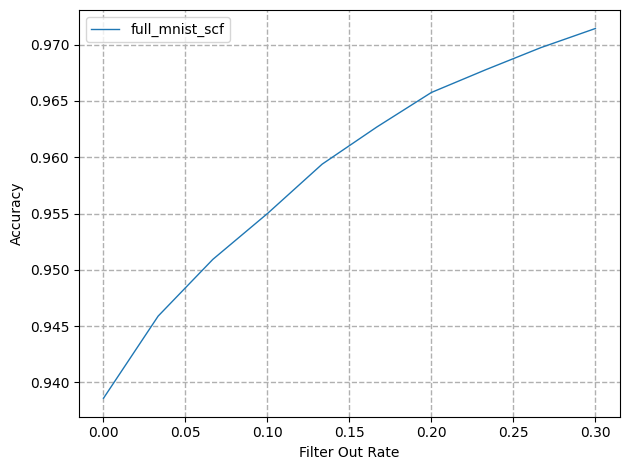

In [9]:
fractions = [0, 0.3, 10]
fractions_linspace = np.linspace(fractions[0], fractions[1], fractions[2])

model_names = [
    "full_mnist_scf",
]
features_list = [
    (features, labels, kappa),
]
fig = get_rejection_accuracy(model_names, features_list, fractions, softmax_weights)
fig.show()

#### Create OSFR protocol

In [61]:
number_to_ids = {number: [] for number in range(10)}
for i in range(len(mnist_ds_test)):
    number = mnist_ds_test[i][1]
    number_to_ids[number].append(i)

In [62]:
def approximate_split(a, chunk_size):
    return np.split(a[: (len(a) // chunk_size) * chunk_size], len(a) // chunk_size)


num_oog_numbers = 5
num_images_in_template_oog = 10
num_images_in_template = 5
rng = np.random.default_rng(0)
oog_numbers = set(rng.choice(np.arange(10), num_oog_numbers, replace=False))
gallery_numbers = set(np.arange(10)).difference(oog_numbers)

# create oog templates
oog_number_to_templates = {}
for number in oog_numbers:
    number_images = np.array(number_to_ids[number]).copy()
    rng.shuffle(number_images)
    oog_number_to_templates[number] = approximate_split(
        number_images, num_images_in_template_oog
    )

# create gallery and in-gallery probe templates
gallery_number_to_templates = {}
probe_in_gallery_number_to_templates = {}

for number in gallery_numbers:
    number_images = np.array(number_to_ids[number]).copy()
    rng.shuffle(number_images)
    number_images_gallery, number_images_gallery_probe = np.split(
        number_images[: (len(number_images) // 2) * 2], 2
    )
    gallery_number_to_templates[number] = approximate_split(
        number_images_gallery, num_images_in_template
    )
    probe_in_gallery_number_to_templates[number] = approximate_split(
        number_images_gallery_probe, num_images_in_template
    )

#### Compute baseline OSFR metrics

In [87]:
def mean_pooling(features, templates):
    pooled_template_features = {}
    for number in templates:
        embs = []
        for template in templates[number]:
            mean_vector = np.mean(features[template], axis=0, keepdims=True)
            embs.append(mean_vector / np.linalg.norm(mean_vector))
        pooled_template_features[number] = embs
    return pooled_template_features


pooled_oog_features = mean_pooling(features, oog_number_to_templates)
pooled_gallery_features = mean_pooling(features, gallery_number_to_templates)
pooled_probe_in_gallery_features = mean_pooling(
    features, probe_in_gallery_number_to_templates
)

In [103]:
def concatenate_features(pooled_features):
    labels = []
    features = []
    for number in pooled_features:
        labels += [number] * len(pooled_features[number])
        features.append(np.concatenate(pooled_features[number], axis=0))
    return np.concatenate(features, axis=0), np.array(labels)


oog_features, oog_labels = concatenate_features(pooled_oog_features)
gallery_features, gallery_labels = concatenate_features(pooled_gallery_features)
probe_in_gallery_features, probe_in_gallery_labels = concatenate_features(
    pooled_probe_in_gallery_features
)

In [104]:
a = oog_features @ gallery_features.T
b = probe_in_gallery_features @ gallery_features.T

In [132]:
oog_similarity = oog_features @ gallery_features.T
in_gallery_similarity = probe_in_gallery_features @ gallery_features.T
oog_accetance_score = np.max(oog_similarity, axis=1)
in_gallery_accetance_score = np.max(in_gallery_similarity, axis=1)
in_gallery_pred_class = gallery_labels[np.argmax(in_gallery_similarity, axis=1)]

true_class_pred = in_gallery_pred_class == probe_in_gallery_labels
# taus = np.linspace(oog_accetance_score.min(), 1, 30)
taus = np.linspace(oog_accetance_score.min(), 1, 30)
fars = []
dirs = []

for tau in np.sort(oog_accetance_score):
    far = np.mean(oog_accetance_score > tau)
    dir = np.mean(np.logical_and(in_gallery_accetance_score > tau, true_class_pred))
    fars.append(far)
    dirs.append(dir)

In [133]:
len(oog_accetance_score)

493

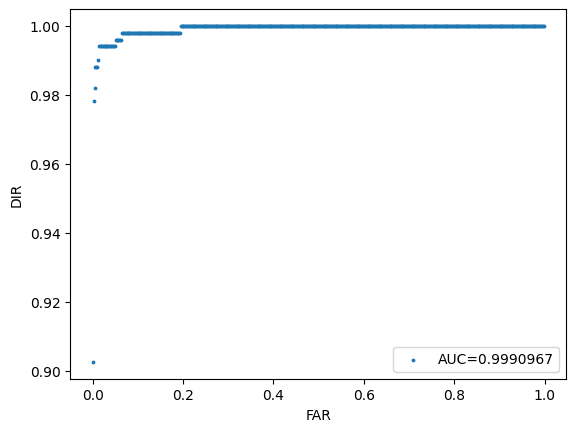

In [139]:
import matplotlib.pyplot as plt

plt.scatter(fars, dirs, label=f"AUC={np.round(np.mean(dirs),7)}", s=3)

plt.xlabel("FAR")
plt.ylabel("DIR")
plt.legend()